#### Описание проекта  
Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.
Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

### Загрузка данных

In [3]:
#pip install plotly==5.5.0

In [4]:
#pip install phik --user

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings('ignore')

In [6]:
try:
    df = pd.read_csv('./datasets/insurance.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')

df.head()


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


* Пропусков нет
* Тип данных корректный

In [8]:
df[df.duplicated()==True].sort_values('Возраст').head(10)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
2429,1,18.0,39800.0,2,0
2512,1,19.0,43200.0,1,0
2269,1,19.0,43200.0,1,0
4129,1,19.0,35600.0,2,0
2853,0,19.0,51700.0,0,0
2694,1,19.0,52600.0,0,0
4935,1,19.0,32700.0,0,0
4726,1,19.0,31700.0,1,0
887,1,19.0,35500.0,0,0
3419,1,19.0,41600.0,1,0


* Есть дубликаты, и смущает, что зарплата сходится рубль в рубль. Пока оставлю, допуская вероятность того, что в кредитном брокере сотрудник выбирает уровень дохода из списка или брокер округляет указанную сумму.

In [9]:
df['Зарплата'].value_counts().sort_values(ascending=False)

45800.0    29
37100.0    28
41500.0    27
43200.0    27
46800.0    26
           ..
63500.0     1
62600.0     1
15200.0     1
65900.0     1
56800.0     1
Name: Зарплата, Length: 524, dtype: int64

Да, похоже на то. Довольно много повторяющихся значений, шаг зарплаты - 100

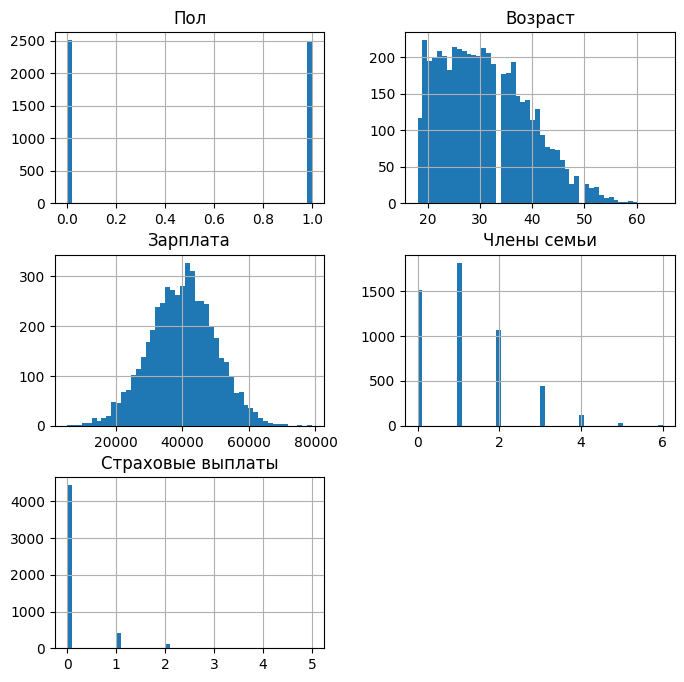

In [10]:
df.hist(figsize=(8,8), bins = 50)
plt.show()

In [11]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Сильных выпадов я не вижу. Возраст от 18 до 65 скорее всего ограничен програмно. Смущает 5 в страховых выплатах. Также стоит посмотреть на значения.

In [12]:
df['Страховые выплаты'].value_counts()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: Страховые выплаты, dtype: int64

В целом я допускаю, что одному и тому же человека могли сделать несколько выплат, хотя можно заменить все, что больше 1 на 1.

In [13]:
fig = px.imshow(df.corr().round(2),text_auto=True,width=600)
fig.show()

* Мы видим, что между собой признаки не коррелируют.
* Есть корреляция Целевого столбца и возраста 0.65, но для нас это не критично, нам важно, чтобы признаки не коррелировали между собой.

In [14]:
phik_overview = df.phik_matrix(df.columns)
fig1 = px.imshow(phik_overview.round(2),text_auto=True,width=600)
fig1.show()

Метод Phik также не установил существенных связей между признаками, что возволяет нам использовать модель линейной регрессии.

#### Выводы из 1 части:
1. В целом качество данных находита на хорошем уровне:
    * Нет пропусков
    * Есть дубликаты, но было решено их оставить, т.к. не хватает информации и они адекватны
    * Типы данных соответствуют значениям
2. Мы выяснили какие столбцы являются признаками и какой столбец является целевым.
3. Мы проверили двумя способами связи между столбцами. Только один столбец коррелирует с целевым, а признаки между собой не коррелируют, что дает нам право использовать метод линейной регрессии при построении модели.

### Умножение матриц  
Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Умножим матрицу признаков X на обратимую матрицу P:

$$
a' = (XP)w'
$$


$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$

Согласно свойству обратной матрицы:
$$
(AB)^{-1}=B^{-1}A^{-1}
$$
$$
w' = ((XP)^T XP)^{-1} (XP)^T y = (P^TX^TXP)^{-1}P^TX^Ty
$$

$$
w' = P^{-1}(X^{T} X)^{-1}(P^T)^{-1}P^TX^Ty
$$
$$
w' = P^{-1}(X^{T} X)^{-1}EX^Ty = P^{-1}(X^{T} X)^{-1}X^Ty
$$
Правая - чать - это w
$$
w' = P^{-1}w
$$

$$
a' = XPw'=XPP^{-1}w=XEw=Xw=a
$$

Итого мы выяснили, что при умножении на обратимую матрицу коэффициенты линейной регрессии не изменятся. Что и требовалось.

#### Выводы из 2 части:
1. Используя свойства умножения матриц мы пришли к тому, что если умножить матрицу признаков на обратимую матрицу, предсказания a по признакам X Будут равняться предсказаниям по признакам XP.
2. Из этого следует, что и параметры линейной регрессии R2 буду идентичны.

### Алгоритм преобразования


В п.2 мы доказали, что если умножить признаки на обратимую матрицу, мы сможем получить такие же предсказания как и с изначальными данными, если заново обучим модель.  
В этом случае та матрица, на которую мы умножали в дальнейшем станет ключом, с помощью которого мы сможем восстановить исходные данные. 
Алгоритм преобразования будет следующим:
1. Сгенерировать случайную матрицу размером X * X, где X - количество признаков.
2. Проверить ее на обратимость.
3. В случае успеха сохраняем ее как ключ для дальнейшей расшифровки и умножаем матрицу признаков на нее.
4. Обучаем модель по новым признакам.
5. Получаем идентичные предсказания, которые можно будет использовать в работе и не беспокоиться за их конфиденциальность, ведь для не обладающего ключом это будут случайные цифры.
6. При обучении модели важно, чтобы значение R2 почти не отличалось от модели, построенной на непреобразованных данных

### Проверка алгоритма
Отлично, благодаря 2 функциям мы разработали алгоритм, который при кодировании преобразует данные и выдает ключ, с помощью которого данные можно будет привести к изначальному виду. 

Для начала проверим гипотезу о том, что умножение на обратимую матрицу не искажает предсказания:
1. Обучим модель.
2. Посчитаем основные метрики на изначальной матрице и умноженной. Сравним их.
3. Посмотрим как коррелируют между собой новые метрики.

In [15]:
model = LinearRegression()
X = df.drop('Страховые выплаты', axis=1)
y = df['Страховые выплаты']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=12345)

for i in [X_train, X_test, y_train, y_test]:
    display(i.shape)


(3750, 4)

(1250, 4)

(3750,)

(1250,)

In [16]:
model.fit(X_train ,y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print ("MSE:",mse)
print ("R2:",r2)

MSE: 0.11660517472525776
R2: 0.43522757127025646


Теперь посмотрим как модель сработает на измененных данных:

In [17]:
matrix = np.random.normal(0, 1, (4, 4))
inv_matrix = np.linalg.inv(matrix)
inv_matrix

array([[-0.83292578, -0.46937539,  0.58111885, -0.04445651],
       [ 1.08676263,  0.16304492,  0.01648201, -0.37624528],
       [ 0.68060712,  0.57819694, -0.03061999, -0.29241688],
       [ 0.26733472,  0.11618186,  0.43978522,  0.21856114]])

Мы сразу проверили матрицу на обратимость, все в порядке.

Теперь рассчитаем новые веса для обычной матрицы:

In [18]:
X_train_new = X_train @ matrix
X_test_new = X_test @ matrix
model_new = LinearRegression()
model_new.fit(X_train_new,y_train)
predictions_new = model_new.predict(X_test_new)
mse_new = mean_squared_error(y_test, predictions_new)
r2_new = r2_score(y_test, predictions_new)
print ("MSE_new:",mse_new)
print ("R2_new:",r2_new)
print ("MSE_diff", mse-mse_new)
print ("R2_diff", r2-r2_new)

MSE_new: 0.11660517472520805
R2_new: 0.43522757127049727
MSE_diff 4.9710235927591384e-14
R2_diff -2.4080737404119645e-13


Отлично, качество модели не изменилось.

In [19]:
#Вес изначальной матрицы
w = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
#Вектор предсказаний
a = X_train @ w
#Вес измененной матрицы
w1 = np.linalg.inv(X_train_new.T.dot(X_train_new)).dot(X_train_new.T).dot(y_train)
#Вектор предсказаний для измененной матрицы
a1 = X_train_new @ w1
#Суммарные отличия разниц 2 векторов
print (sum(a1-a))



-9.761452992815278e-05


Разработаем универсальную функцию кодирования, которая на вход будет принимать датафрейм с презнаками, а на выходе выдавать преобразованный датафрейм и ключ в виде обратимой матрицы.

In [20]:
def coding(X_for_code):
    matrix = np.random.randint(100,size = (4, 4))
    encoded_features = X_for_code.dot(matrix)
    return encoded_features,matrix

X_coded = coding(X)
X_coded[0].head(5)

,0,1,2,3
0,846445.0,1342835.0,1092934.0,2184842.0
1,649534.0,1030019.0,837944.0,1674679.0
2,359175.0,569494.0,463218.0,925653.0
3,710643.0,1127832.0,918306.0,1836111.0
4,445886.0,707154.0,575376.0,1150044.0


Ранее мы доказали, что даже при видоизменении данных, можно будет обучить модель и получить такое же качество. Теперь нам нужно написать функцию, которая позволит вернуться к изначальным данным, т.к. произвести дешифровку. На вход она будет принимать измененную матрицу, а на выходе должна дать изначальную.

In [21]:
def decoding(coded,matrix):
    decoded_features = abs(round(coded @ np.linalg.inv(matrix)))
    decoded_features.columns = X.columns
    return decoded_features

display(decoding(X_coded[0],X_coded[1]).head(5))
display(X.head(5))

,Пол,Возраст,Зарплата,Члены семьи
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0


### Итоговые выводы

1. Изначально у нас был датафрейм. В первой части мы провели предобработку данных, изучили их и разбили на несколько выборок.
2. После этого убедились в том, что шифровка данных путем умножения на обратимую матрицу не приводит к ухудшению качества данных. Мы доказали, что изменив признаки и обучив модель по новым признакам, мы получим идентичные предсказания.
3. Разработали метод шифровки, который генерирует ключ в виде матрицы и позволяет хранить данные в зашифрованном виде.
4. Проверили алгоритм на практике и убедились в высокой точности данного метода.
5. Также в ходе работы была обучена модель, которая предсказывает целевой признак со следующими характеристиками:
    * MSE = 0.11
    * R2 = 0.43
6. Выполнив проверку получили идентичные данные, сравнили их точечно и убедились, что все работает.  
Благодаря данной работе заказчик сможет не беспокоиться о хранении данных, ведь они будут зашифрованы. Также ключ при необходимости можно будет поменять, но при это нужно будет произвести процедуру дешифровки и шифрования повторно.